In [31]:
import numpy as np
import pandas as pd
import IPython.display as ipd
import scipy.io.wavfile as wav
from scipy.fftpack import dct
from zipfile import ZipFile
import matplotlib.pyplot as plt
from scipy.stats import skew
import os,glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

#### The function below returns a dataframe containing all file paths and their corresponding label

In [2]:
def generate_path(base_path):
    temp = []
    for types in dialects: 
        df = pd.DataFrame()
        base_dir = base_path + str(types)
        files = glob.glob(base_dir+'/*.wav')
        y = [types]*len(files)
        df["FILE"] = files
        df["OUTPUT"] = y
        temp.append(df)
    return pd.concat(temp).reset_index(drop=True)

In [3]:
def generate_audio_frames(fs,audio,frameSize,frameOverlap):
    frameLen, frameLap = int(round(fs*frameSize)), int(round(fs*frameOverlap))
    audioLen = len(audio)
    paddingLen = frameLap - (audioLen - frameLen) % frameLap #making number of frames even
    paddedAudio = np.concatenate((audio, np.zeros(paddingLen)), axis = 0)
    audioLen = len(paddedAudio)
    numberOfFrames = int(np.floor((audioLen - frameLen)/frameLap) + 1)
    indices = np.tile(np.arange(0, frameLen), (numberOfFrames, 1)) + np.tile((np.arange(0, numberOfFrames*frameLap, frameLap)), (frameLen, 1)).T
    frames = paddedAudio[indices]
    return frames, frameLen

In [4]:
def apply_hamming(frames,frameLen):
    frames = frames * np.hamming(frameLen)
    return frames

In [5]:
def power_spectrum(frames, nfft):
    mag_frames = np.absolute(np.fft.rfft(frames, nfft))  # Magnitude of the FFT
    pow_frames = np.square(mag_frames)/nfft  # Power Spectrum
    return pow_frames

In [6]:
def generate_filter_bank(fs,num_banks,nfft):
    
    hz_to_mel = lambda x: (2595 * np.log10(1 + (x / 2) / 700))
    mel_to_hz = lambda x: (700*(np.power(10, x/2595) - 1))
    
    lower_mel = 0
    upper_mel = hz_to_mel(fs)
    mel_points = np.linspace(lower_mel, upper_mel, num_banks + 2)
    hz_points = mel_to_hz(mel_points)
    bins = np.floor((nfft + 1) * hz_points/fs)
    
    fbank = np.zeros((num_banks, int(np.floor(nfft/2 + 1))))
    for m in range(1, num_banks + 1):
        left = int(bins[m - 1])
        center = int(bins[m])
        right = int(bins[m + 1])
        for k in range(left, center):
            fbank[m - 1, k] = (k - bins[m - 1])/(bins[m] - bins[m - 1])
        for k in range(center, right):
            fbank[m - 1, k] = (bins[m + 1] - k)/(bins[m + 1] - bins[m])
    return fbank

In [7]:
def apply_filter_banks(power_frames,fbank):
    filter_banks = np.dot(power_frames, fbank.T)
    #for numerical stability
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks) #if condition is true, return eps, else return original val
    filter_banks = 20*np.log10(filter_banks)
    return filter_banks

In [8]:
def generate_mfcc(filterBanks,num_ceps):
    mfcc = dct(filterBanks, type = 2, axis = 1, norm = 'ortho')[:, 1:(num_ceps + 1)]
    return mfcc  

In [9]:
def audio_feature_extraction(audio_path,frameLen,frameOverlap,nfft,num_fbanks,num_ceps):
    fs, audio = wav.read(audio_path)
    frm,frmlen = generate_audio_frames(fs,audio,frameLen,frameOverlap)
    frm = apply_hamming(frm,frmlen)
    pow_frm = power_spectrum(frm,nfft)
    fbank = generate_filter_bank(fs,num_fbanks,nfft)
    filter_banks = apply_filter_banks(pow_frm,fbank)
    mfcc = generate_mfcc(filter_banks,num_ceps)
    return mfcc

In [10]:
framelength = 0.025
frameoverlap = 0.015
nfft = 512
num_fbanks = 40
num_ceps = 20
N = 2
dialects = [1,2,3,4,5,6,7,8,9]
dataset_path = "dataset/IDR"

In [11]:
dataset = generate_path(dataset_path)
dataset.tail()

,FILE,OUTPUT
598,dataset/IDR9/21.wav,9
599,dataset/IDR9/11.wav,9
600,dataset/IDR9/17.wav,9
601,dataset/IDR9/65.wav,9
602,dataset/IDR9/14.wav,9


In [12]:
num = 0
test = dataset["FILE"][num]
mfcc = audio_feature_extraction(test,framelength,frameoverlap,nfft,num_fbanks,num_ceps)

In [13]:
print(len(mfcc[0]))
dataset.shape

20


(603, 2)

In [14]:
features = {
    "mean" : lambda x: np.mean(x,axis=0),
    "min" : lambda x: np.min(x,axis=0),
    "max" : lambda x: np.max(x,axis=0),
    "std_dev" : lambda x: np.std(x,axis=0),
    "median" : lambda x: np.median(x,axis=0)
}

In [15]:
def generate_model_data(df,size=100):
    df = df.sample(frac=1).reset_index(drop=True)
    col = []
    y = []
    for key in features.keys():
        for i in range(1,num_ceps+1):
            col.append(key + str(i))
    rows = []
    for index, row in df.iterrows():
        if(index<size):
            temp = []
            y.append(row["OUTPUT"])
            path = row["FILE"]
            mfcc = audio_feature_extraction(path,framelength,frameoverlap,nfft,num_fbanks,num_ceps)
            for key in features.keys():
                temp.append(features[key](mfcc))
            rows.append(np.concatenate(temp))
        else:
            break
    feat = pd.DataFrame(rows)
    feat.columns = col
    feat["OUTPUT"] = y
    return feat

In [16]:
df = generate_model_data(dataset,602)

In [17]:
df.shape

(602, 101)

In [18]:
df.head(10)

,std_dev1,std_dev2,std_dev3,std_dev4,std_dev5,std_dev6,std_dev7,std_dev8,std_dev9,std_dev10,...,median12,median13,median14,median15,median16,median17,median18,median19,median20,OUTPUT
0,61.477739,38.084838,24.510173,26.490122,23.667480,18.623375,19.916879,16.474822,15.089634,14.979710,...,-3.291166,-2.395993,-5.223168,-3.475562,-4.067378,1.272803,0.812163,0.105814,0.838971,4
1,63.763669,33.352536,27.064837,19.916422,28.544695,18.936541,17.230588,16.866343,12.850586,12.037657,...,-12.358763,-4.928455,-13.633332,-5.507632,-2.932206,-5.650121,-6.144465,-1.618524,-5.733053,2
2,74.249432,40.938234,26.496325,19.996271,29.647919,16.427649,16.937654,14.666912,12.942415,14.263035,...,2.231309,-0.357192,-3.252009,0.941497,-4.575722,-2.433802,-0.917846,-2.214484,-1.383270,1
3,62.872320,58.301550,27.141424,30.706458,24.932294,18.764672,21.077773,14.612645,13.371913,13.596997,...,-4.956702,-1.765099,-5.228703,2.393419,3.440595,5.803185,1.806004,2.095920,-0.022405,6
4,56.679256,40.138100,25.139297,22.474362,23.474647,19.622719,23.716843,18.343243,15.971959,12.244565,...,-4.536735,0.372624,-12.809762,-5.211764,2.061588,-0.352669,-3.675908,1.442589,-1.112065,4
5,63.729380,41.573626,26.243790,29.617044,25.724695,23.237806,18.250034,16.133567,12.978891,12.972562,...,-0.728272,-1.777540,-4.965374,1.771653,1.548168,0.737022,-2.555795,0.471123,-3.351337,6
6,59.413059,38.608440,25.507042,20.236966,21.654204,16.366229,21.757653,15.854108,14.852527,12.371568,...,-2.968406,-4.915173,-7.096346,3.047375,-0.575156,1.146308,-2.592629,-1.443796,-2.587269,8
7,62.409471,42.031502,24.791086,23.908253,25.159384,19.447092,20.777915,16.491607,14.264455,11.911513,...,-13.792638,-3.620104,-2.205447,-14.004355,-6.157436,1.269544,-8.268186,-1.646209,-2.533038,4
8,67.873162,40.903657,29.073496,27.067530,24.714286,19.433879,20.182238,17.141123,13.993949,12.854350,...,0.574479,-4.304471,-2.863055,4.533514,1.101521,2.472193,4.786512,4.334830,3.521403,1
9,61.159000,39.420850,22.972079,27.863168,20.339885,16.926907,19.129165,14.375669,12.347429,12.208975,...,-3.984110,-2.483104,-4.884073,0.912156,2.670953,4.199082,6.346206,6.895960,7.631443,8


In [77]:
data_train, data_test = train_test_split(df, test_size=0.3, shuffle=True)
x_train = data_train.drop(data_train[['OUTPUT']],axis=1)
y_train = data_train[['OUTPUT']]

x_test = data_test.drop(data_test[['OUTPUT']],axis=1)
y_test = data_test[['OUTPUT']]

In [95]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

clf = SVC(gamma='auto', kernel='linear')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
clf.score(x_test, y_test)

/home/timetraveller05/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9723756906077348

[[20  0  0  0  0  0  0  0  0]
 [ 2 12  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0]
 [ 0  0  0  0 20  0  1  0  0]
 [ 0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  2  0  0  0  0  0 17  0]
 [ 0  0  0  0  0  0  0  0 19]]


[Text(0, 0, ''),
 Text(0, 0, 'dialect_1'),
 Text(0, 0, 'dialect_2'),
 Text(0, 0, 'dialect_3'),
 Text(0, 0, 'dialect_4'),
 Text(0, 0, 'dialect_5'),
 Text(0, 0, 'dialect_6'),
 Text(0, 0, 'dialect_7'),
 Text(0, 0, 'dialect_8'),
 Text(0, 0, 'dialect_9')]

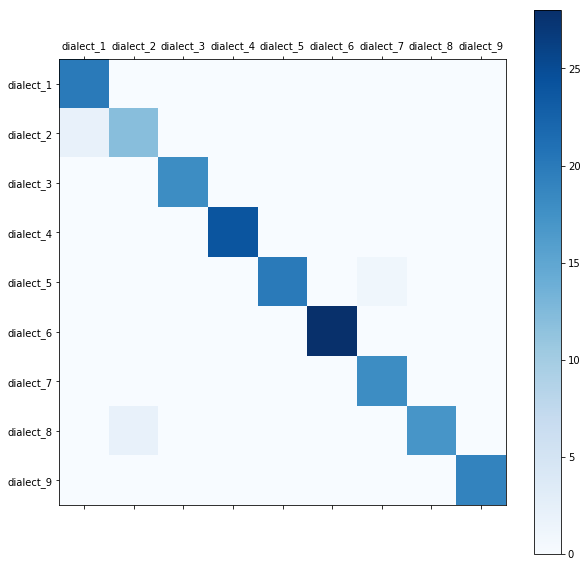

In [96]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
dialects = ['dialect_1', 'dialect_2', 'dialect_3', 'dialect_4', 'dialect_5', 'dialect_6', 'dialect_7', 'dialect_8', 'dialect_9']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([""] + dialects)
ax.set_yticklabels([""] + dialects)


In [97]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
lr.score(x_test, y_test)

/home/timetraveller05/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/timetraveller05/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9613259668508287

[[20  0  0  0  0  0  0  0  0]
 [ 0 12  1  0  1  0  0  0  0]
 [ 0  0 17  0  0  0  0  1  0]
 [ 0  0  0 24  0  0  0  0  0]
 [ 0  0  0  0 20  0  1  0  0]
 [ 0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  2  0  0  0  0  0 17  0]
 [ 0  0  1  0  0  0  0  0 18]]


[Text(0, 0, ''),
 Text(0, 0, 'dialect_1'),
 Text(0, 0, 'dialect_2'),
 Text(0, 0, 'dialect_3'),
 Text(0, 0, 'dialect_4'),
 Text(0, 0, 'dialect_5'),
 Text(0, 0, 'dialect_6'),
 Text(0, 0, 'dialect_7'),
 Text(0, 0, 'dialect_8'),
 Text(0, 0, 'dialect_9')]

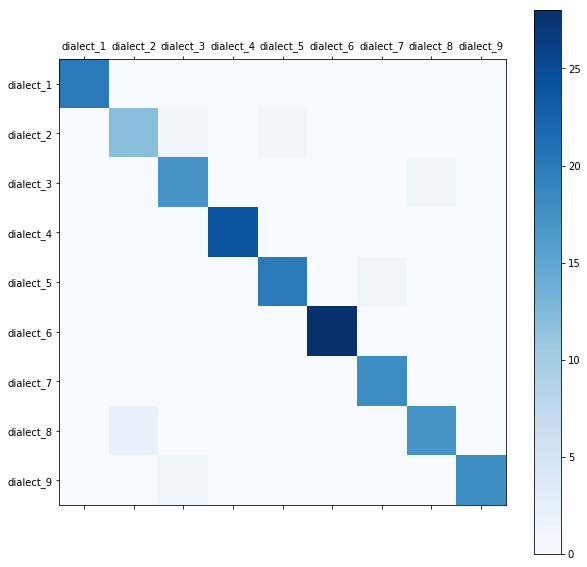

In [98]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
dialects = ['dialect_1', 'dialect_2', 'dialect_3', 'dialect_4', 'dialect_5', 'dialect_6', 'dialect_7', 'dialect_8', 'dialect_9']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([""] + dialects)
ax.set_yticklabels([""] + dialects)


In [99]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
knn.score(x_test, y_test)

/home/timetraveller05/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.9668508287292817

[[20  0  0  0  0  0  0  0  0]
 [ 0 11  2  0  1  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  1]
 [ 0  0  0  0 21  0  0  0  0]
 [ 1  0  0  0  0 27  0  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  1  0  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  0 19]]


[Text(0, 0, ''),
 Text(0, 0, 'dialect_1'),
 Text(0, 0, 'dialect_2'),
 Text(0, 0, 'dialect_3'),
 Text(0, 0, 'dialect_4'),
 Text(0, 0, 'dialect_5'),
 Text(0, 0, 'dialect_6'),
 Text(0, 0, 'dialect_7'),
 Text(0, 0, 'dialect_8'),
 Text(0, 0, 'dialect_9')]

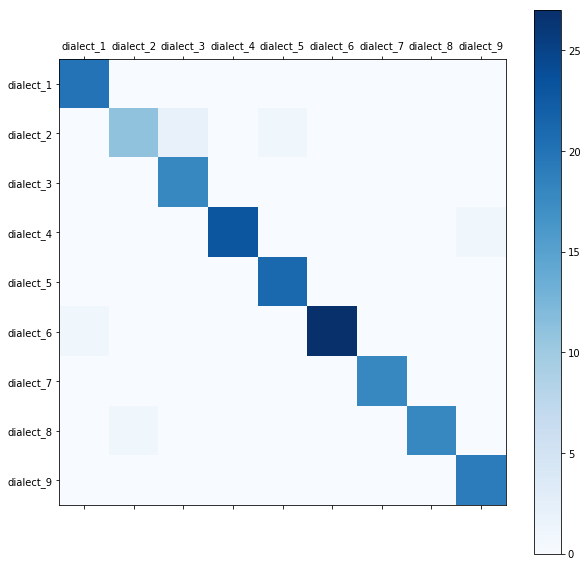

In [100]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
dialects = ['dialect_1', 'dialect_2', 'dialect_3', 'dialect_4', 'dialect_5', 'dialect_6', 'dialect_7', 'dialect_8', 'dialect_9']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([""] + dialects)
ax.set_yticklabels([""] + dialects)


In [101]:
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

/home/timetraveller05/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.988950276243094

[[20  0  0  0  0  0  0  0  0]
 [ 0 11  2  0  1  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  1]
 [ 0  0  0  0 21  0  0  0  0]
 [ 1  0  0  0  0 27  0  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  1  0  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  0 19]]


[Text(0, 0, ''),
 Text(0, 0, 'dialect_1'),
 Text(0, 0, 'dialect_2'),
 Text(0, 0, 'dialect_3'),
 Text(0, 0, 'dialect_4'),
 Text(0, 0, 'dialect_5'),
 Text(0, 0, 'dialect_6'),
 Text(0, 0, 'dialect_7'),
 Text(0, 0, 'dialect_8'),
 Text(0, 0, 'dialect_9')]

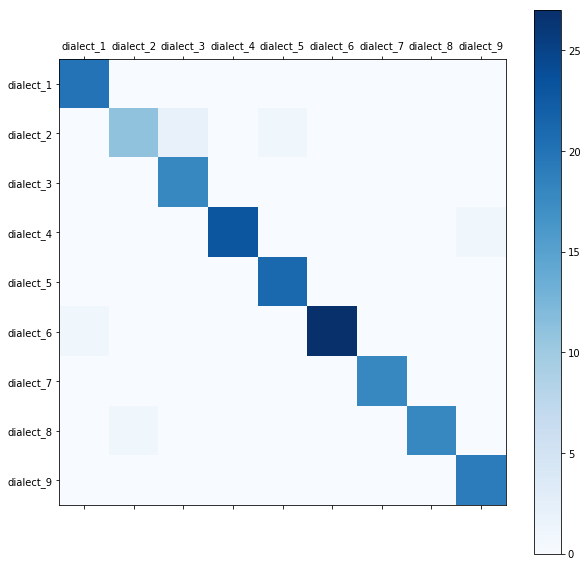

In [102]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
dialects = ['dialect_1', 'dialect_2', 'dialect_3', 'dialect_4', 'dialect_5', 'dialect_6', 'dialect_7', 'dialect_8', 'dialect_9']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([""] + dialects)
ax.set_yticklabels([""] + dialects)
